# Propagation Evolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from PIL import Image
import matplotlib.patches as patches

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [125]:
class Diffractive_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小20e-6，z方向传播0.002。
    def __init__(self, λ = 532e-9, N_pixels = 28*5, pixel_size = 20e-6, distance = 0.01):
        super(Diffractive_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp))
        self.phase = torch.exp(1j * kz * distance).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        E = E.to(device)
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * self.phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

In [130]:
def propagation_along_z(initial_field, wl, N_pixels, pixel_size, z_step, number_of_z_steps):
    diffraction_step = Diffractive_Layer(distance = z_step, λ = wl, N_pixels = N_pixels, pixel_size = pixel_size)
    z_ind = np.arange(0, number_of_z_steps)
    full_cross_section =  torch.zeros((len(z_ind),N_pixels, N_pixels),dtype = torch.complex64)
    full_cross_section[0] = torch.tensor(initial_field)
    with torch.no_grad():
        for ind in z_ind[1:]:
            full_cross_section[ind] = diffraction_step(full_cross_section[ind-1])
        return full_cross_section

DISCRETIZATION_STEP = 1.0e-6 # 网格大小
N_pixels = 512 # xy平面边长的元素点数量
z_step = 1e-5 # z方向步长
number_of_z_steps = 500 # z方向步数
z = np.arange(0, number_of_z_steps)*z_step # z坐标
wl = 532e-9 # 波长
coord_limit = (N_pixels//2)*DISCRETIZATION_STEP # 建立xy坐标系
# 拉网格
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)
x, y = np.meshgrid(mesh, mesh)

In [131]:
# 高斯光束传输演化
BEAM_SIZE = 15e-6
beam = np.exp(-(x**2+y**2)/BEAM_SIZE**2)
field = propagation_along_z(beam, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

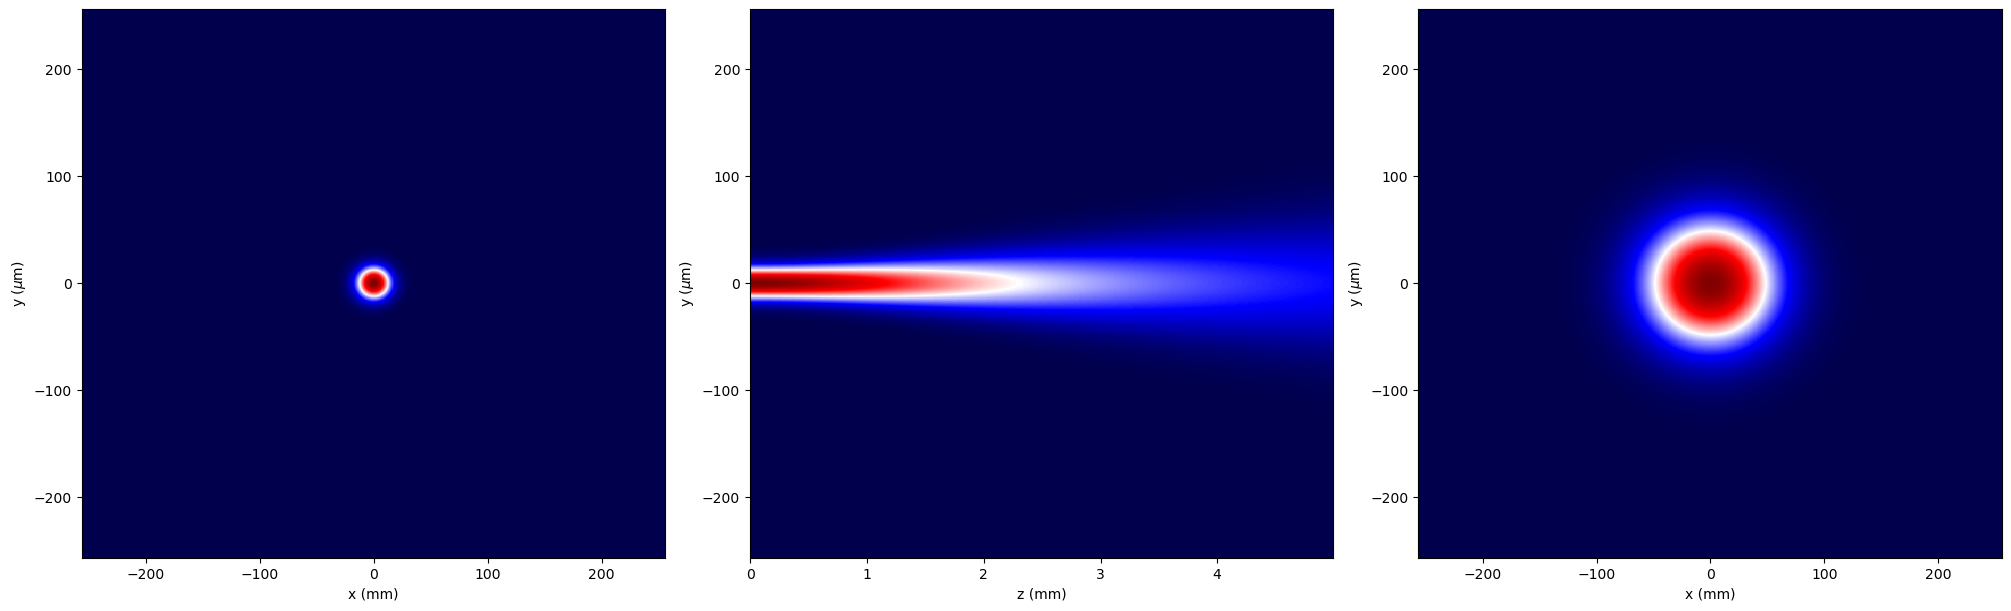

In [132]:
plt.rcParams["figure.figsize"] = (20, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)

# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap = 'seismic')
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y ($\mu$m)')

# yx cross-section
YZ_field = torch.abs(field[:, N_pixels//2])
ax2.pcolormesh(z*10**3, mesh*10**6, YZ_field.T, cmap = 'seismic')
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')

# output
XY_field_out = torch.abs(field[-1]).T
ax3.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap = 'seismic')
ax3.set_xlabel('x (mm)')
ax3.set_ylabel('y ($\mu$m)')

plt.show()

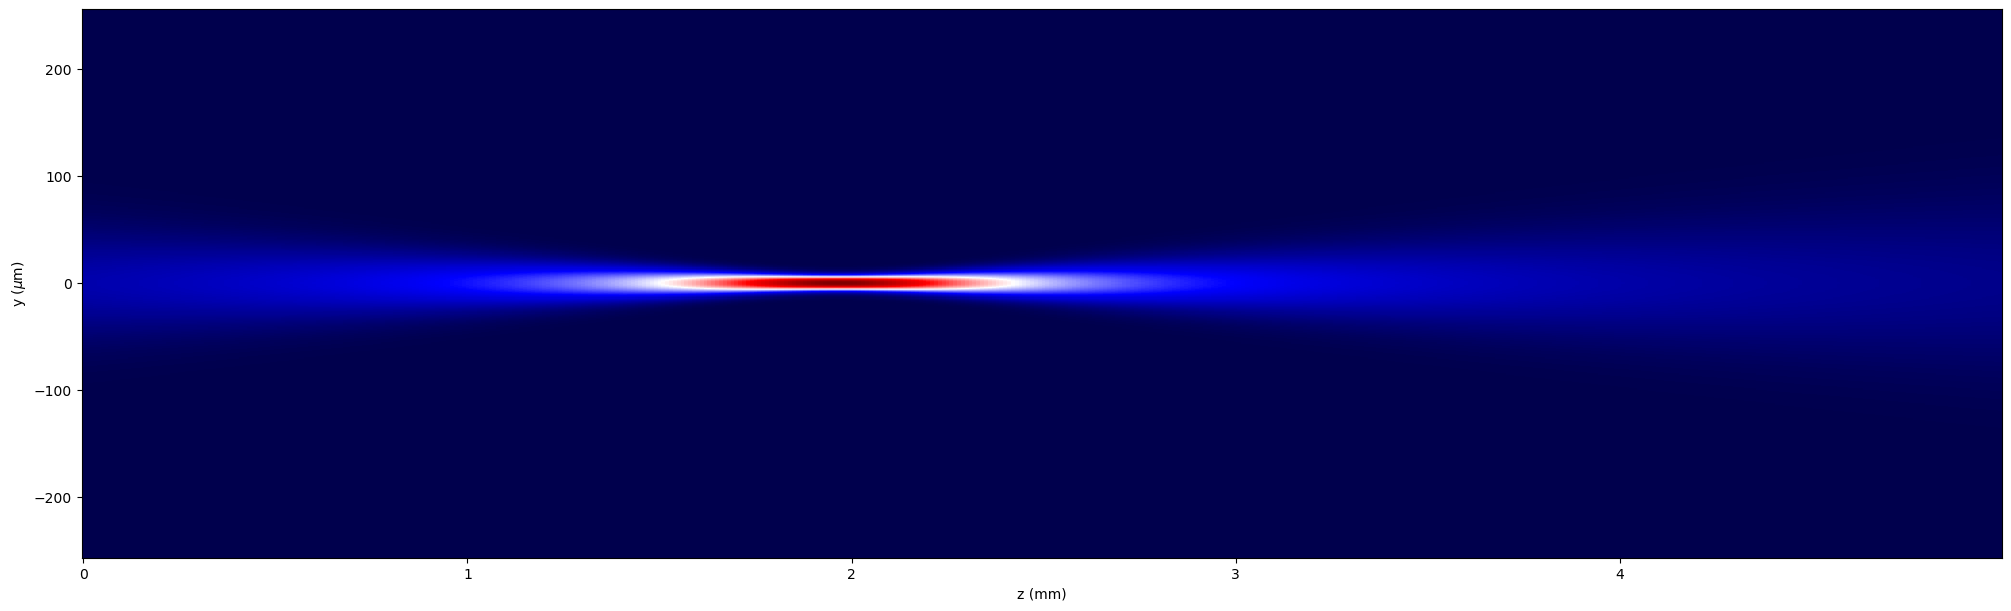

In [87]:
BEAM_SIZE = 50e-6
beam = np.exp(-(x**2+y**2)/BEAM_SIZE**2)

f = 2e-3
field_lens = beam*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out = propagation_along_z(field_lens, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

fig, ax = plt.subplots(1, constrained_layout=True)
# yx cross-section
YZ_field_lens = torch.abs(field_out[:, N_pixels//2])
ax.pcolormesh(z*10**3, mesh*10**6, YZ_field_lens.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20172\1940330428.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


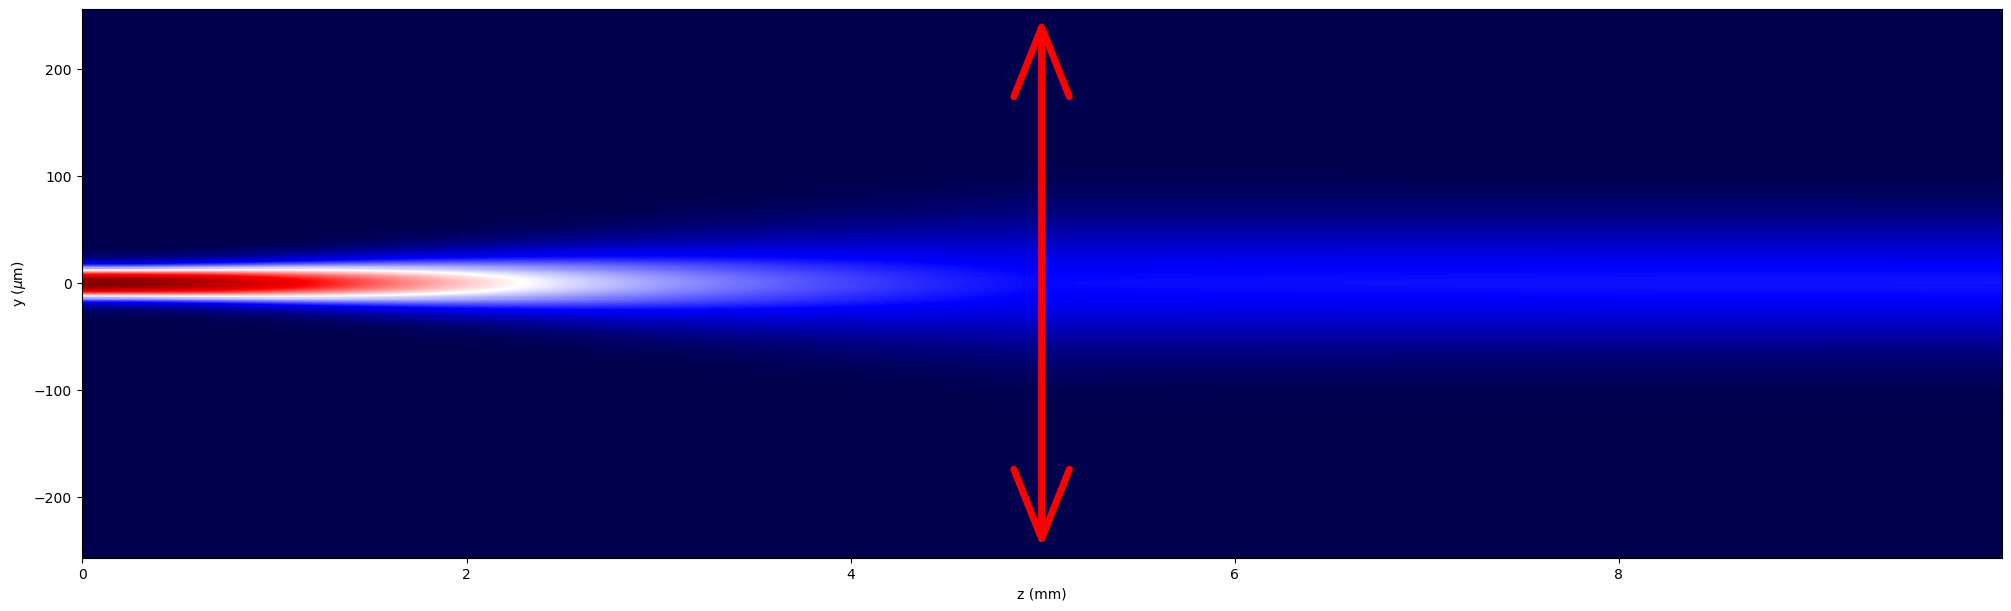

In [88]:
f = 5e-3
field_lens = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out = propagation_along_z(field_lens, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

fig, ax = plt.subplots(1, constrained_layout=True)
# yx cross-section
YZ_field_lens = torch.abs(field_out[:, N_pixels//2])
YZ_field_total = torch.cat((YZ_field, YZ_field_lens), dim = 0)
z_total = np.arange(0, 2*number_of_z_steps)*z_step # z坐标

ax.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_total.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.annotate('', xy=(max(z_total*10**3)/2, -250), xytext=(max(z_total*10**3)/2, 250), 
             arrowprops=dict(arrowstyle='<->, head_length=5, head_width=2', lw=5, color='red'))

plt.show()


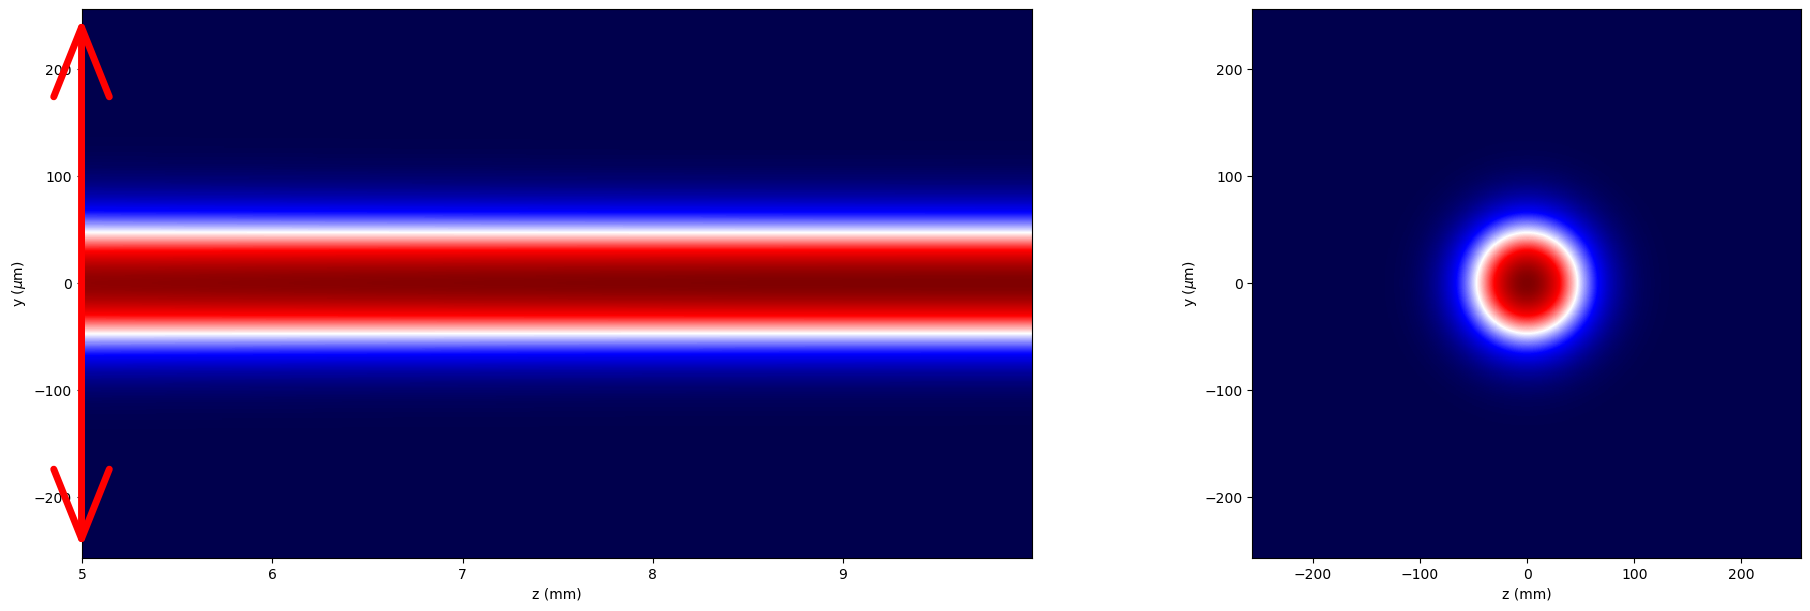

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
# yx cross-section
YZ_field_lens = torch.abs(field_out[:, N_pixels//2])
# YZ_field_total = torch.cat((YZ_field, YZ_field_lens), dim = 0)
z_total = np.arange(number_of_z_steps, 2*number_of_z_steps)*z_step # z坐标

ax1.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_lens.T, cmap = 'seismic')
ax1.set_xlabel('z (mm)')
ax1.set_ylabel('y ($\mu$m)')

ax1.annotate('', xy=(max(z_total*10**3)/2, -250), xytext=(max(z_total*10**3)/2, 250), 
             arrowprops=dict(arrowstyle='<->, head_length=5, head_width=2', lw=5, color='red'))

# yx cross-section
XY_field_out_lens = torch.abs(field_out[-1]).T
ax2.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out_lens.T, cmap = 'seismic')
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')
ax2.axis('square')

plt.show()

In [90]:
f = 5e-3
field_lens1 = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens1 = propagation_along_z(field_lens1, wl, N_pixels, DISCRETIZATION_STEP, z_step, 2*number_of_z_steps)
field_lens2 = field_out_lens1[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens2 = propagation_along_z(field_lens2, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

YZ_field_lens1 = torch.abs(field_out_lens1[:, N_pixels//2])
YZ_field_lens2 = torch.abs(field_out_lens2[:, N_pixels//2])
YZ_field_total = torch.cat((YZ_field, YZ_field_lens1, YZ_field_lens2), dim = 0)
z_total = np.arange(0, 4*number_of_z_steps)*z_step # z坐标

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20172\1940330428.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


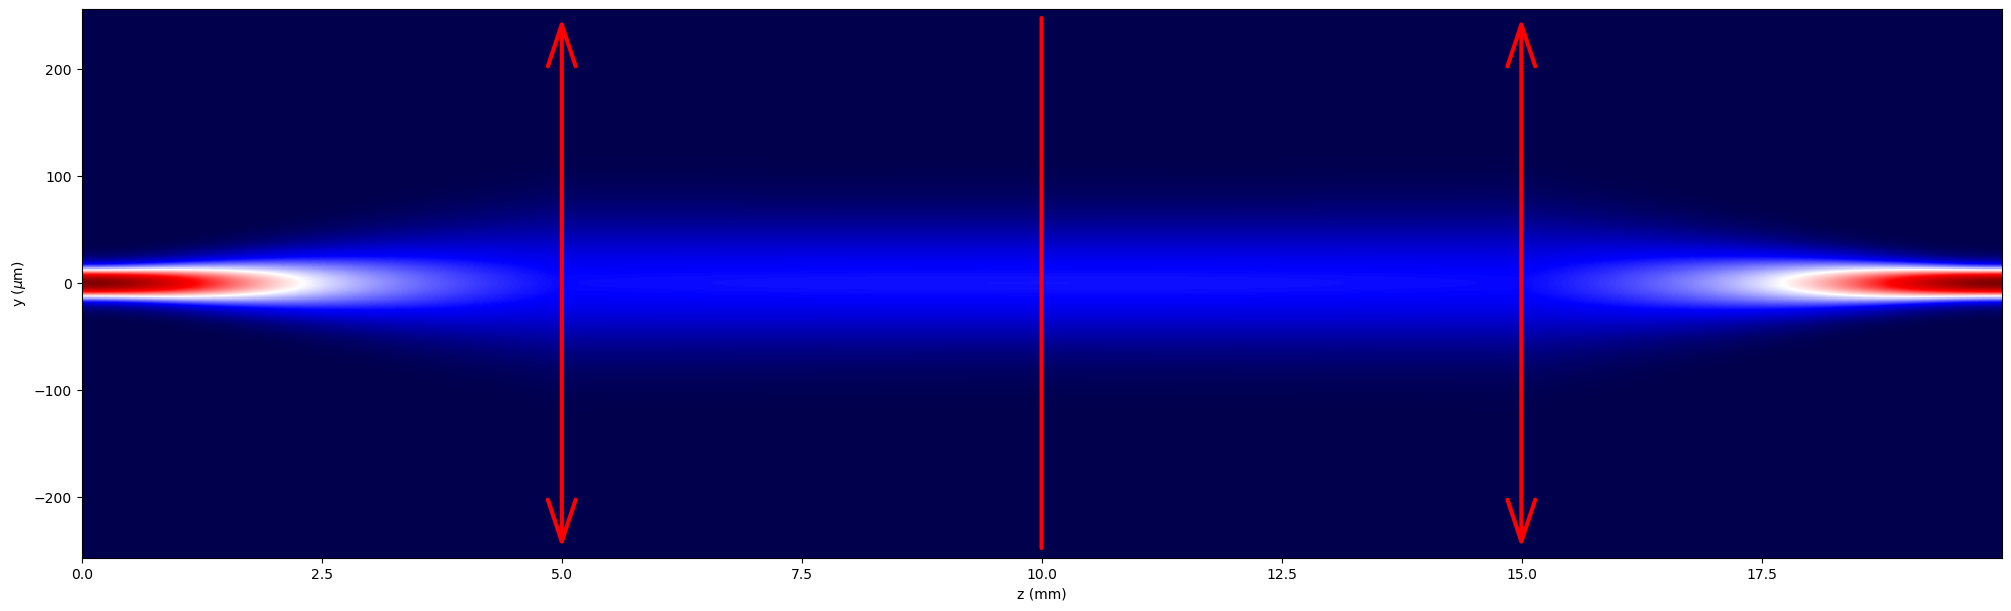

In [91]:
# yx cross-section
fig, ax = plt.subplots(1, constrained_layout=True)
ax.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_total.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.annotate('', xy=(max(z_total*10**3)/4, -250), xytext=(max(z_total*10**3)/4, 250), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)/2, -250), xytext=(max(z_total*10**3)/2, 250), 
             arrowprops=dict(arrowstyle='-', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)*3/4, -250), xytext=(max(z_total*10**3)*3/4, 250), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.show()

In [92]:
full_int = (torch.abs(field)**2).sum(dim=(1,2)) # 统计总光强
print(full_int)

tensor([353.4292, 353.4290, 353.4289, 353.4287, 353.4286, 353.4284, 353.4283,
        353.4281, 353.4280, 353.4278, 353.4276, 353.4275, 353.4273, 353.4272,
        353.4270, 353.4269, 353.4267, 353.4266, 353.4264, 353.4263, 353.4261,
        353.4259, 353.4258, 353.4256, 353.4255, 353.4254, 353.4252, 353.4250,
        353.4249, 353.4247, 353.4246, 353.4244, 353.4243, 353.4241, 353.4240,
        353.4238, 353.4237, 353.4235, 353.4234, 353.4232, 353.4231, 353.4229,
        353.4228, 353.4226, 353.4225, 353.4223, 353.4221, 353.4220, 353.4219,
        353.4217, 353.4215, 353.4214, 353.4213, 353.4211, 353.4209, 353.4208,
        353.4207, 353.4205, 353.4203, 353.4202, 353.4200, 353.4199, 353.4197,
        353.4196, 353.4194, 353.4193, 353.4191, 353.4189, 353.4188, 353.4187,
        353.4185, 353.4183, 353.4182, 353.4181, 353.4179, 353.4177, 353.4176,
        353.4174, 353.4173, 353.4171, 353.4170, 353.4168, 353.4167, 353.4165,
        353.4164, 353.4162, 353.4161, 353.4159, 353.4158, 353.41

In [93]:
BATCH_SIZE = 200
IMG_SIZE = 128
N_pixels = 256
PADDING = (N_pixels - IMG_SIZE) // 2  # 避免边缘信息丢失

# 数据预处理并加载
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE))])
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定义一个绘图函数
def image_plot(image_E, label):
    norm = np.absolute(image_E.cpu().numpy())
    fig, ax = plt.subplots()
    ax.imshow(np.round(norm, 5), cmap = 'seismic') # 显示图片每个像素点的振幅
    ax.axis('off')
    ax.set_title("E_norm & label={}".format(label))
#     fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax2)
    plt.show()

batch_number [100/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


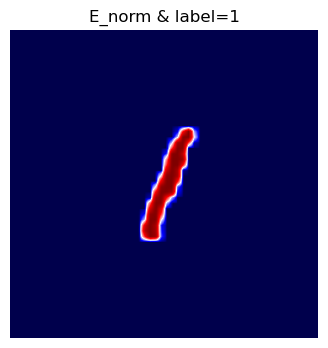

batch_number [200/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


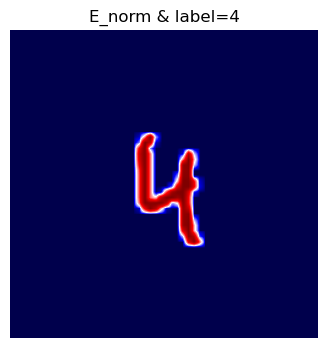

batch_number [300/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


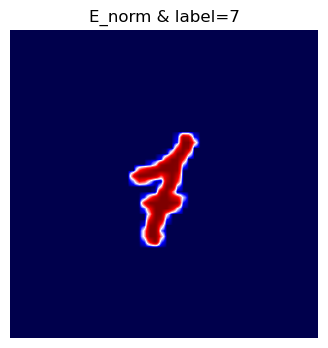

In [94]:
plt.rcParams["figure.figsize"] = (4, 4)
for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    images_padded = F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING))
    images_E = torch.sqrt(images_padded)
    labels = labels.to(device)
    if (i + 1) % 100 == 0:
        classes = torch.unique(labels).cpu().numpy()
        classes_num = len(classes)
        print('batch_number [{}/{}]'.format(i + 1, len(train_dataloader)))
        print('classes of the first batch: {}, number of classes: {}'.format(classes, classes_num))#  第一个batch的总类
        image_plot(images_E[0], labels[0])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20172\1940330428.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


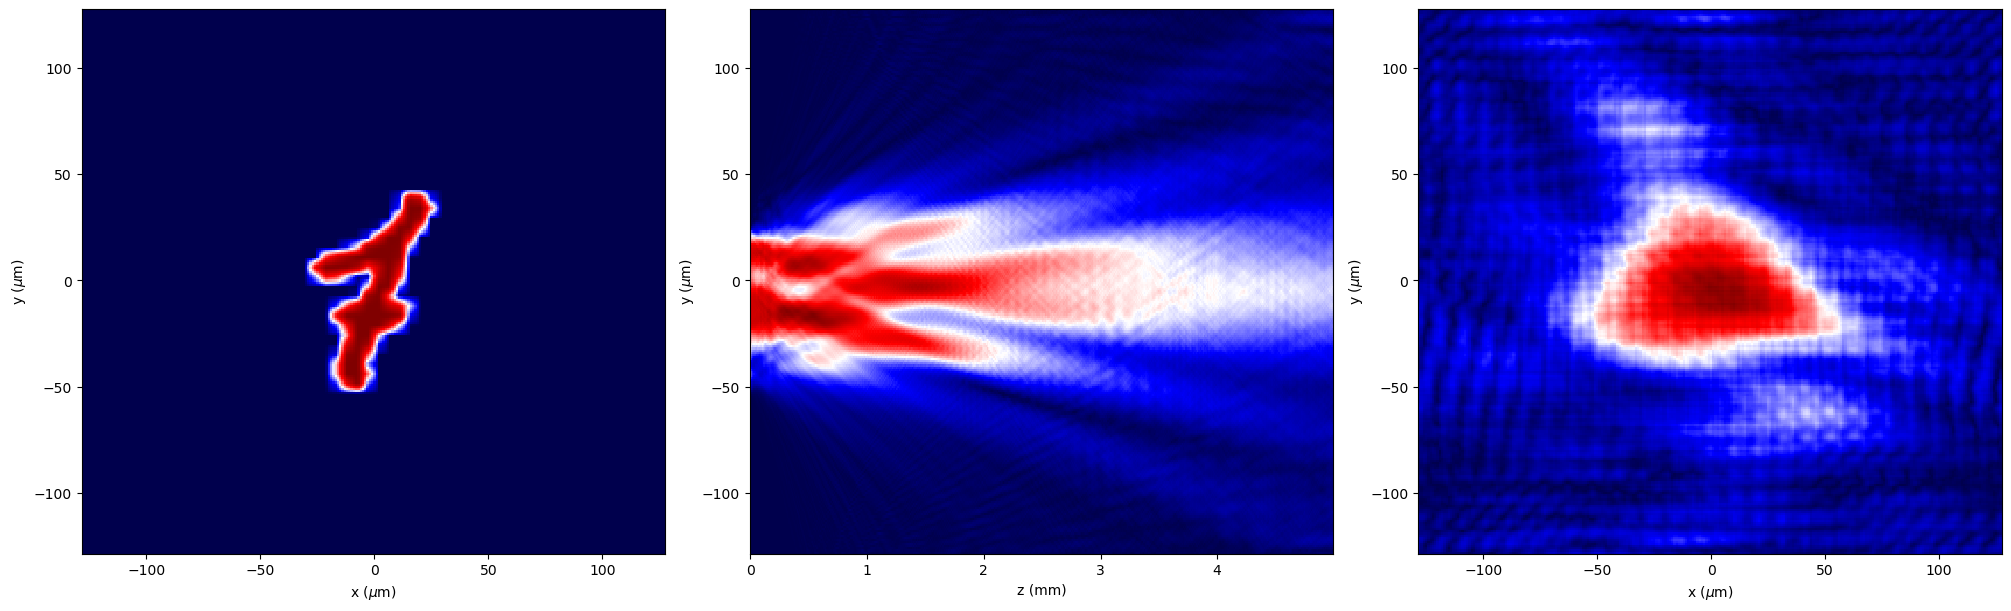

In [95]:
z_step = 1e-5 # z方向步长
number_of_z_steps = 500 # z方向步数
z = np.arange(0, number_of_z_steps)*z_step # z坐标
DISCRETIZATION_STEP = 1.0e-6 # 网格大小

coord_limit = (N_pixels//2)*DISCRETIZATION_STEP # 建立xy坐标系
# 拉网格
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)
x, y = np.meshgrid(mesh, mesh)

images_input = torch.flip(images_E[0], [0])
field = propagation_along_z(images_input, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.rcParams["figure.figsize"] = (20, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)
cmap = 'seismic'

# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')

# yz cross-section
YZ_field = torch.abs(field[:, :, N_pixels//2])
ax2.pcolormesh(z*10**3, mesh*10**6, YZ_field.T, cmap=cmap)
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')

# output
XY_field_out = torch.abs(field[-1]).T
ax3.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T, cmap=cmap)
ax3.set_xlabel('x ($\mu$m)')
ax3.set_ylabel('y ($\mu$m)')

plt.show()

In [96]:
full_int = (torch.abs(field)**2).sum(dim=(1,2)) # 统计总光强
print(full_int)

tensor([1479.2988, 1479.2986, 1479.2983, 1479.2981, 1479.2980, 1479.2977,
        1479.2974, 1479.2972, 1479.2969, 1479.2969, 1479.2964, 1479.2963,
        1479.2960, 1479.2959, 1479.2957, 1479.2955, 1479.2953, 1479.2950,
        1479.2947, 1479.2947, 1479.2944, 1479.2941, 1479.2938, 1479.2937,
        1479.2935, 1479.2932, 1479.2930, 1479.2927, 1479.2926, 1479.2924,
        1479.2921, 1479.2919, 1479.2915, 1479.2914, 1479.2911, 1479.2909,
        1479.2908, 1479.2905, 1479.2902, 1479.2900, 1479.2898, 1479.2896,
        1479.2893, 1479.2892, 1479.2888, 1479.2886, 1479.2885, 1479.2882,
        1479.2880, 1479.2876, 1479.2875, 1479.2872, 1479.2871, 1479.2869,
        1479.2864, 1479.2861, 1479.2861, 1479.2859, 1479.2856, 1479.2853,
        1479.2850, 1479.2848, 1479.2847, 1479.2844, 1479.2842, 1479.2839,
        1479.2837, 1479.2836, 1479.2832, 1479.2830, 1479.2827, 1479.2825,
        1479.2822, 1479.2820, 1479.2819, 1479.2814, 1479.2812, 1479.2810,
        1479.2808, 1479.2805, 1479.280

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20172\1940330428.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


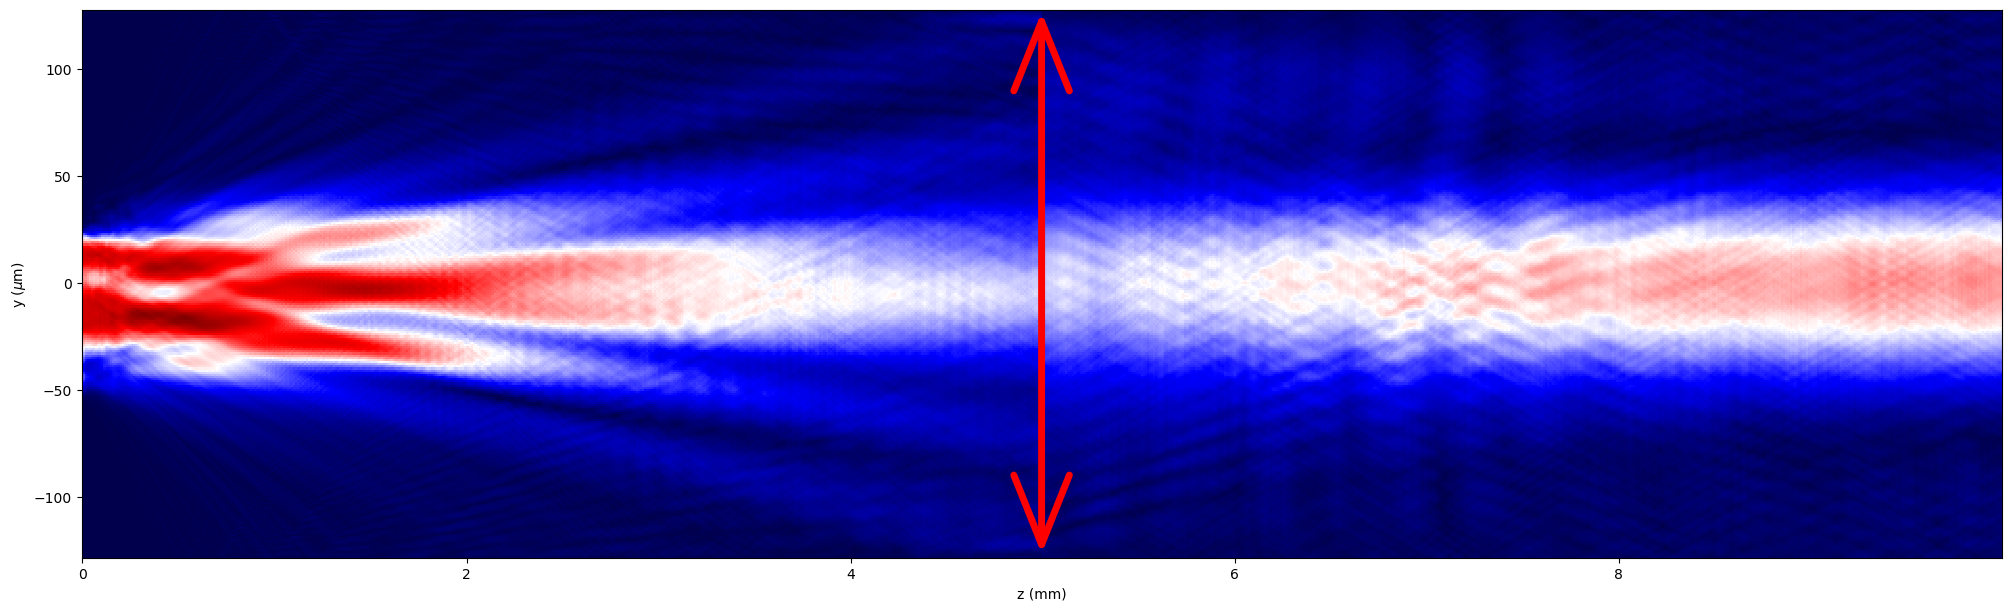

In [101]:
f = 5e-3
field_lens = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out = propagation_along_z(field_lens, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

fig, ax = plt.subplots(1, constrained_layout=True)
# yx cross-section
YZ_field_lens = torch.abs(field_out[:, N_pixels//2])
YZ_field_total = torch.cat((YZ_field, YZ_field_lens), dim = 0)
z_total = np.arange(0, 2*number_of_z_steps)*z_step # z坐标

ax.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_total.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.annotate('', xy=(max(z_total*10**3)/2, -coord_limit*10**6), xytext=(max(z_total*10**3)/2, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=5, head_width=2', lw=5, color='red'))

plt.show()


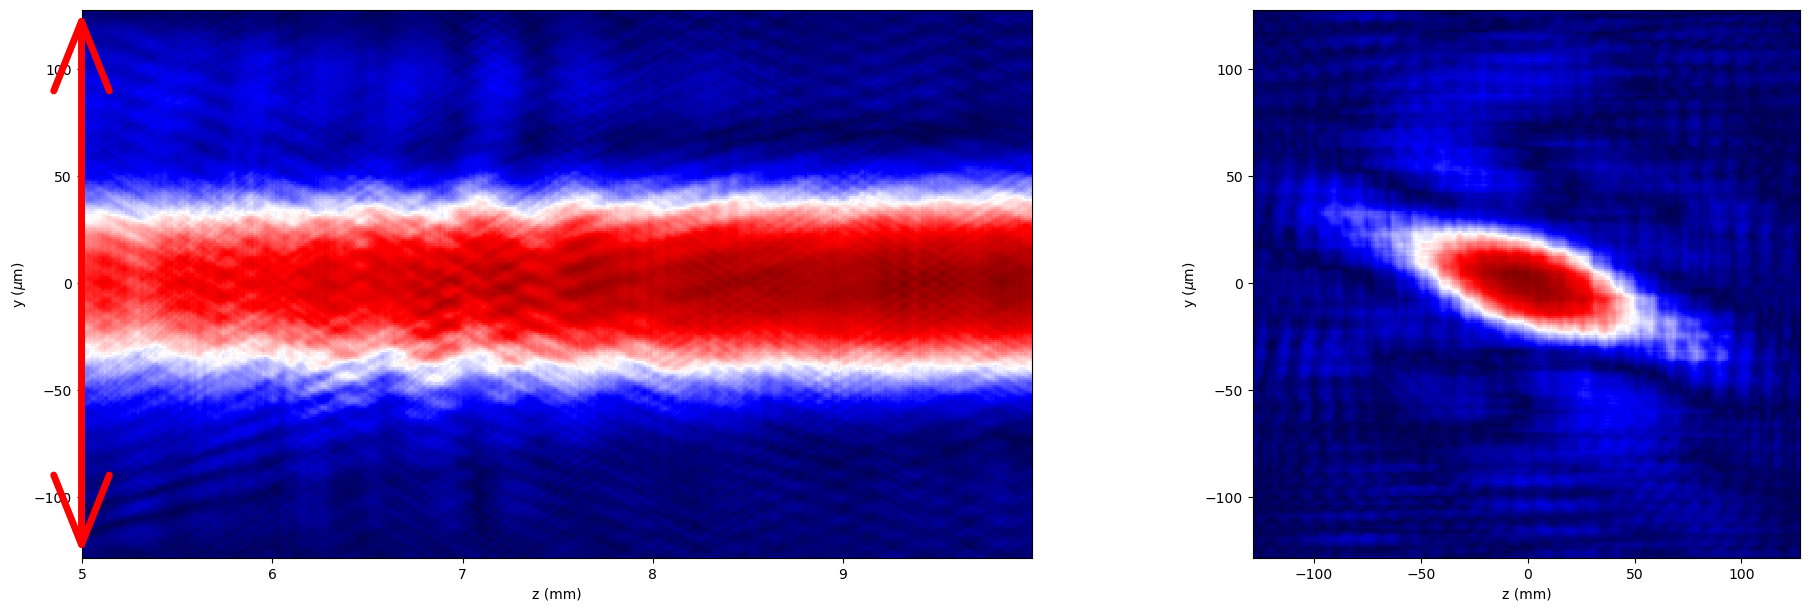

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
# yx cross-section
YZ_field_lens = torch.abs(field_out[:, N_pixels//2])
# YZ_field_total = torch.cat((YZ_field, YZ_field_lens), dim = 0)
z_total = np.arange(number_of_z_steps, 2*number_of_z_steps)*z_step # z坐标

ax1.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_lens.T, cmap = 'seismic')
ax1.set_xlabel('z (mm)')
ax1.set_ylabel('y ($\mu$m)')

ax1.annotate('', xy=(max(z_total*10**3)/2, -coord_limit*10**6), xytext=(max(z_total*10**3)/2, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=5, head_width=2', lw=5, color='red'))

# yx cross-section
XY_field_out_lens = torch.abs(field_out[-1]).T
ax2.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out_lens.T, cmap = 'seismic')
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')
ax2.axis('square')

plt.show()

In [105]:
f = 5e-3
field_lens1 = field[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens1 = propagation_along_z(field_lens1, wl, N_pixels, DISCRETIZATION_STEP, z_step, 2*number_of_z_steps)
field_lens2 = field_out_lens1[-1]*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field_out_lens2 = propagation_along_z(field_lens2, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

YZ_field_lens1 = torch.abs(field_out_lens1[:, N_pixels//2])
YZ_field_lens2 = torch.abs(field_out_lens2[:, N_pixels//2])
YZ_field_total = torch.cat((YZ_field, YZ_field_lens1, YZ_field_lens2), dim = 0)
z_total = np.arange(0, 4*number_of_z_steps)*z_step # z坐标

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20172\1940330428.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


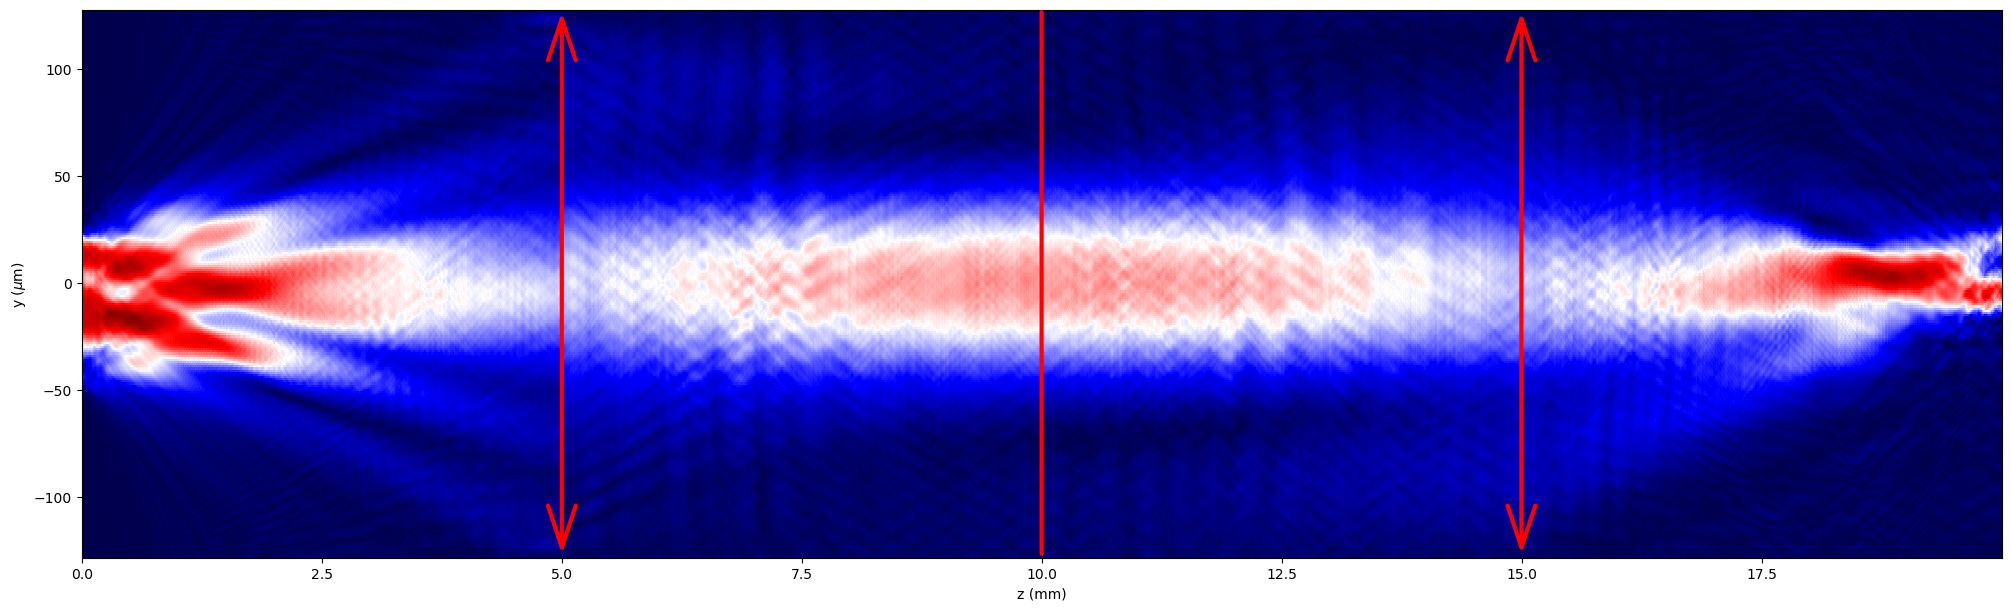

In [106]:
# yx cross-section
fig, ax = plt.subplots(1, constrained_layout=True)
ax.pcolormesh(z_total*10**3, mesh*10**6, YZ_field_total.T, cmap = 'seismic')
ax.set_xlabel('z (mm)')
ax.set_ylabel('y ($\mu$m)')

plt.annotate('', xy=(max(z_total*10**3)/4, -coord_limit*10**6), xytext=(max(z_total*10**3)/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)/2, -coord_limit*10**6), xytext=(max(z_total*10**3)/2, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='-', lw=3, color='red'))

plt.annotate('', xy=(max(z_total*10**3)*3/4, -coord_limit*10**6), xytext=(max(z_total*10**3)*3/4, coord_limit*10**6), 
             arrowprops=dict(arrowstyle='<->, head_length=3, head_width=1', lw=3, color='red'))

plt.show()

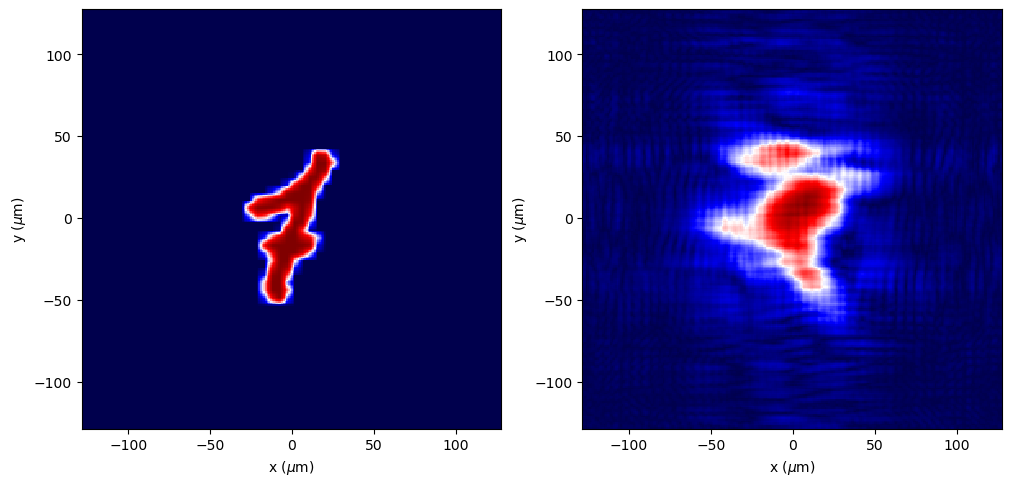

In [124]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in, cmap=cmap)
ax1.set_xlabel('x ($\mu$m)')
ax1.set_ylabel('y ($\mu$m)')
ax1.set_aspect('equal')

# output
XY_field_out_lens2 = torch.abs(field_out_lens2[-250]).T
ax2.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out_lens2.T, cmap=cmap)
ax2.set_xlabel('x ($\mu$m)')
ax2.set_ylabel('y ($\mu$m)')
ax2.set_aspect('equal')

plt.axis('square')
plt.show()

In [123]:
len(field_out_lens2)

500